In [1]:
%load_ext autoreload
%autoreload 1
%aimport ecg_get_data
%aimport Models
%aimport train_test_validat
%aimport self_attention
%aimport ECGplot
import Models 
from train_test_validat import *
from self_attention import *
from  ecg_get_data import *
import ECGplot

import torch
import torch.utils.data as Data
import matplotlib.pyplot as plt

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path =  './npy_ECG/' #路径
lable_path = './label.npy'
EcgChannles_num = 12
EcgLength_num = 5000
lead_index = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

x = load_data(data_path,EcgChannles_num=EcgChannles_num,EcgLength_num=EcgLength_num)
y = load_label(lable_path)

100%|██████████| 1698/1698 [00:09<00:00, 185.08it/s]


In [3]:
test_model_path = "./model/20220909_012816/best_model_0.pt"
test_model = torch.load(test_model_path).to(DEVICE)
test_x = x[44:45]
test_y = y[44:45]
test_x = MAX_MIN_normalization_by_feactures(test_x)
test_x = torch.FloatTensor(test_x)  #turn numpy to tensor
test_y = torch.LongTensor(test_y)
test_dataset = Data.TensorDataset(test_x, test_y)
test_dataloader = Data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
test_model.eval()
attention_value_timestep = np.zeros(312,)
attention_value_lead = np.zeros(12,)
for i,data in enumerate(test_dataloader,0):
    inputs,labels = data[0].to(DEVICE),data[1].to(DEVICE)
    outputs = test_model(inputs)
    #print(labels)
    _,pred = outputs.max(1) # 求概率最大值对应的标签
    print("the label :{labels},pred is {pred}".format(labels=labels[0],pred=pred[0]))
    attention_value_timestep += (((test_model.attention_value2.to('cpu'))[0]).detach().numpy()).sum(axis=0) #将得到的attention值(5000,5000)每行叠加起来，得到（5000，）的attention值
    attention_value_lead += (((test_model.attention_value1.to('cpu'))[0]).detach().numpy()).sum(axis=0) #将得到的attention值(5000,5000)每行叠加起来，得到（5000，）的attention值

the label :1,pred is 1


In [4]:
def MaxMinNormalization(x,Max,Min):
    x = (x - Min) / (Max - Min);
    return x

In [5]:
attention_value_timestep = MaxMinNormalization(attention_value_timestep,attention_value_timestep.max(),attention_value_timestep.min())
attention_value_lead = MaxMinNormalization(attention_value_lead,attention_value_lead.max(),attention_value_lead.min())

In [6]:
attention_value__each_timestep = np.zeros(EcgLength_num,)
factor = int(EcgLength_num/len(attention_value_timestep))
for i in range(0,EcgLength_num,factor):
    if (i/factor)>=len(attention_value_timestep):
        break
    attention_value__each_timestep[i:i+factor] = attention_value_timestep[int(i/factor)]

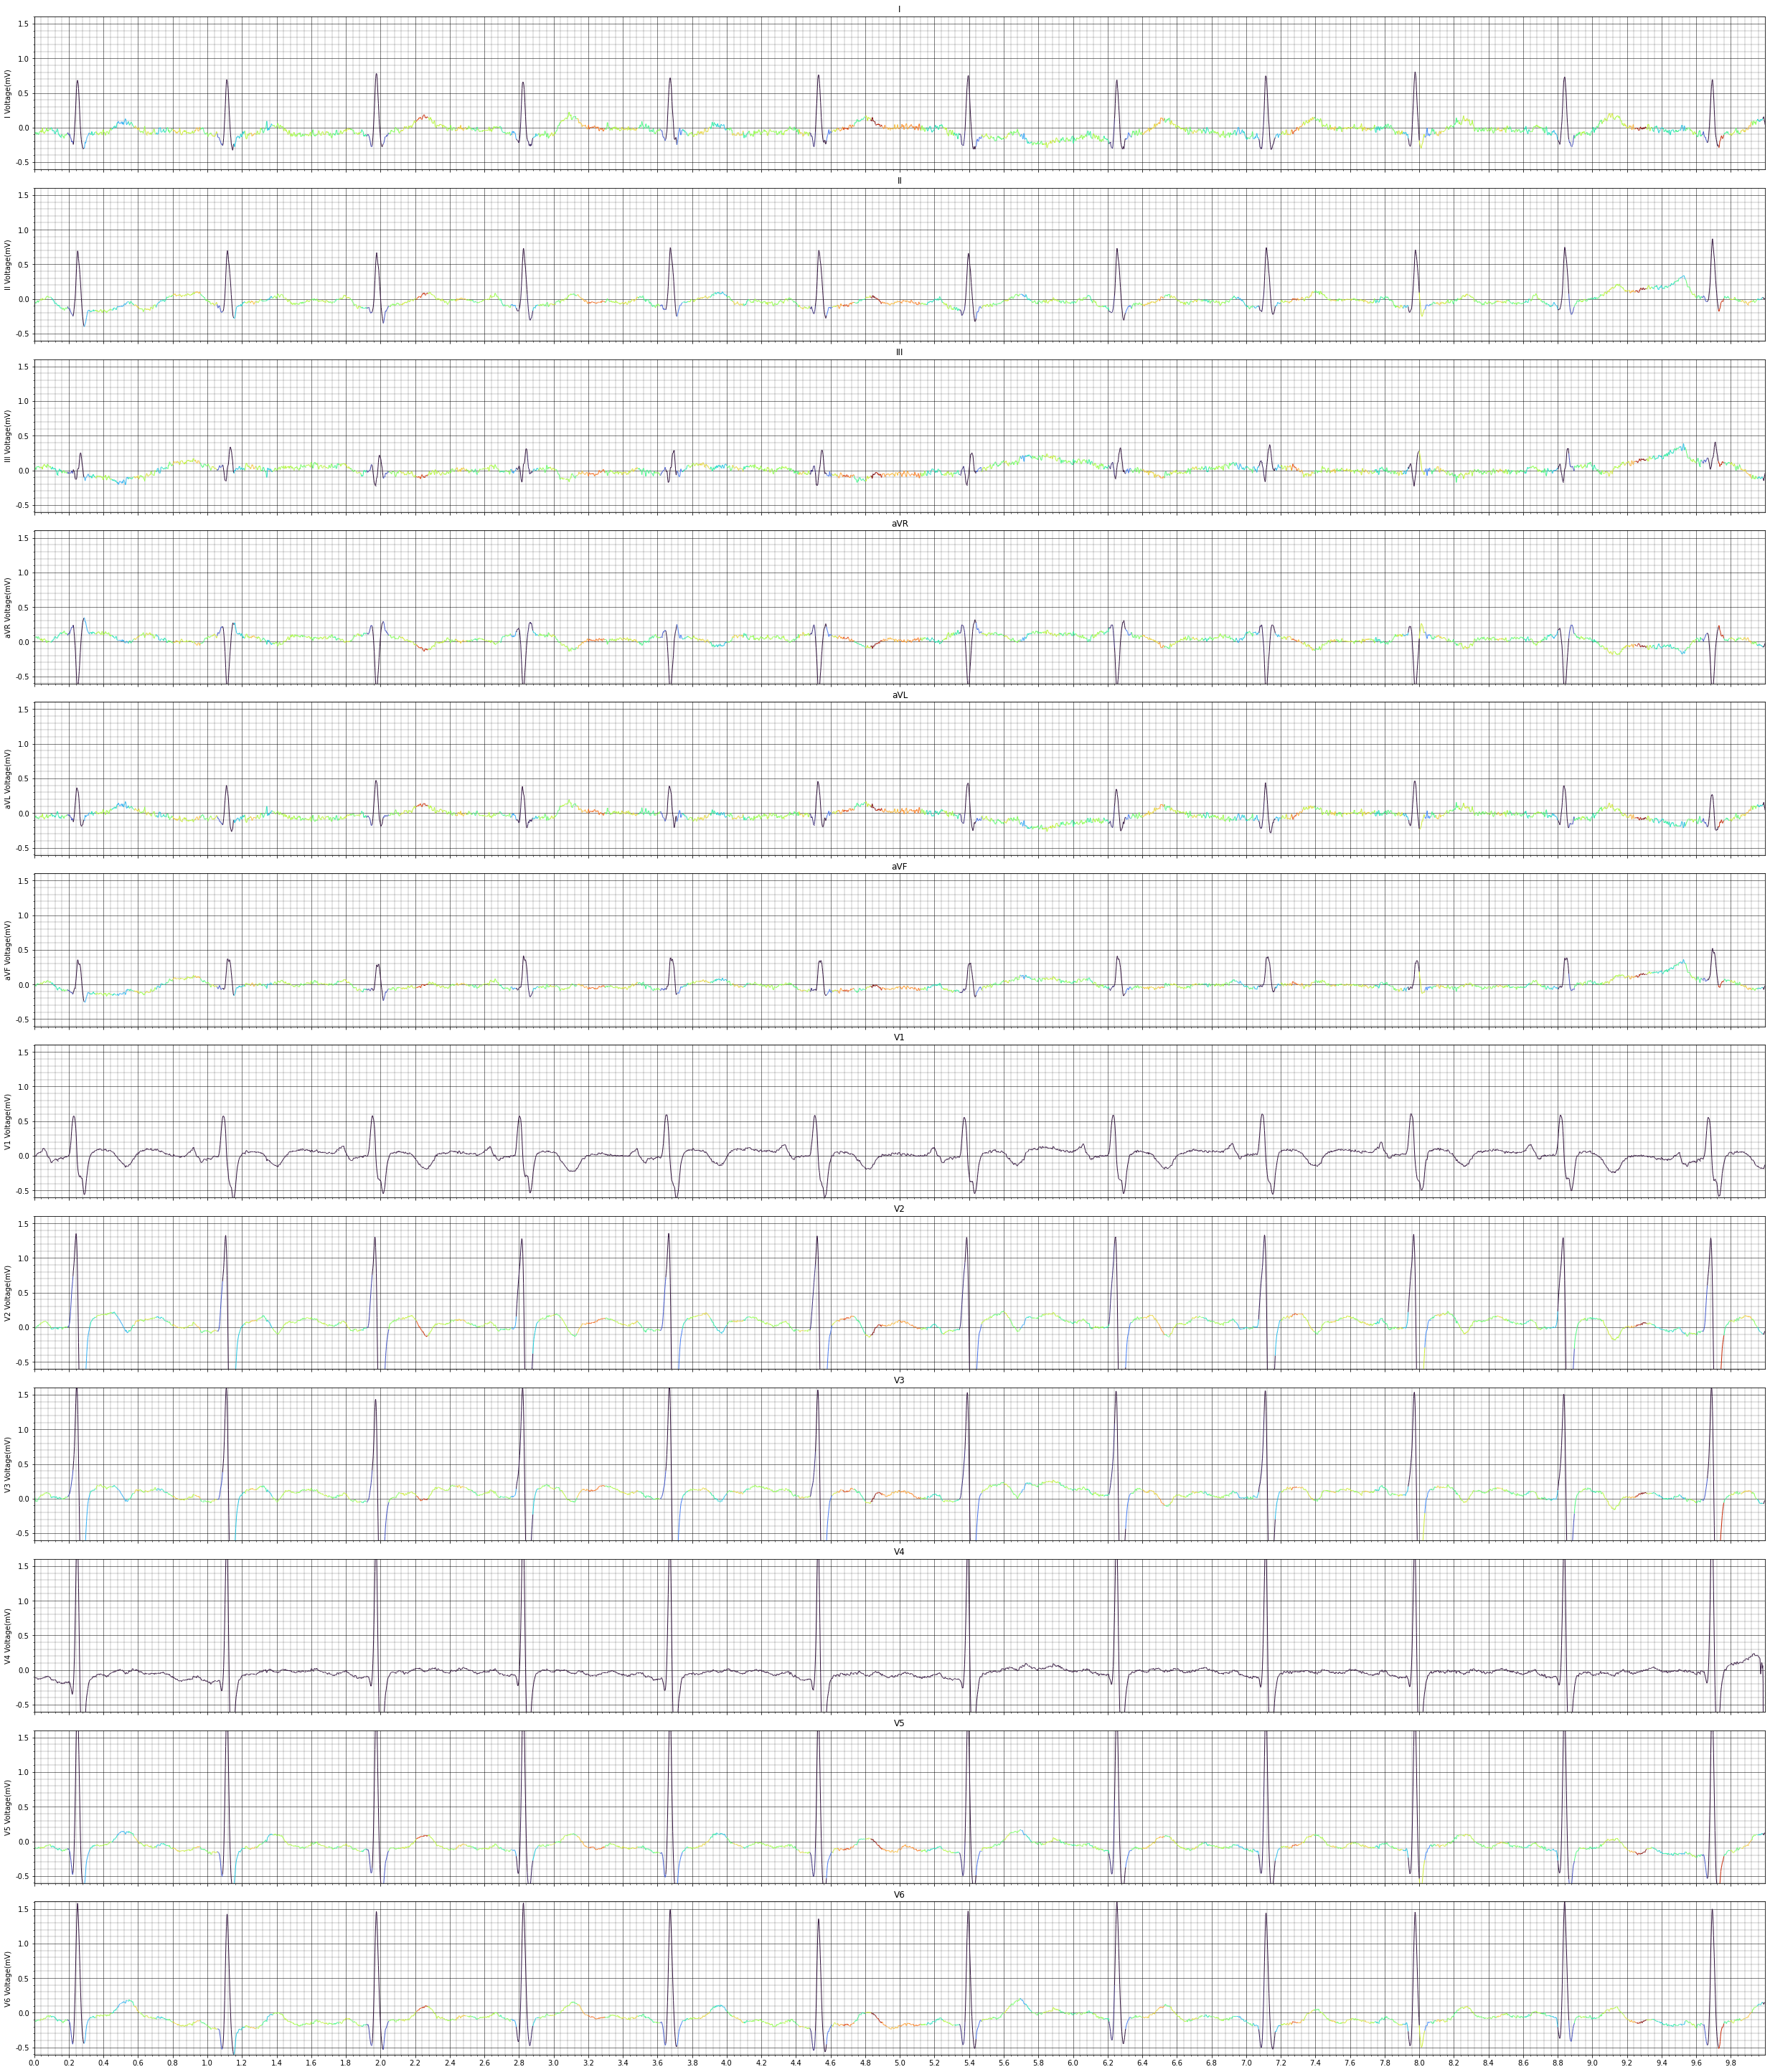

In [43]:
x_index = np.arange(0,EcgLength_num)
fig, axs = plt.subplots(nrows=12, ncols=1, sharex=True,sharey=True,figsize=(100,40), constrained_layout=True)
for i,ax in enumerate(axs.flat):
    plot_y = x[44,i,:]*(4.88)
    ECGplot.plot_multicolored_line(fig,ax,x = x_index,y= plot_y,color_depend=attention_value__each_timestep*attention_value_lead[i],cmap="turbo",y_name = str(lead_index[i])+" Voltage(mV)"
                                    ,title = lead_index[i])

In [45]:
fig.savefig(r"demo.png",dpi=300)